In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import shutil
from shutil import copyfile
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from scipy import ceil
import scipy

In [3]:
source_path = '/content/drive/MyDrive/IndonesiaFood'


list=[]

for i in os.listdir(source_path):
    source_path_item = os.path.join(source_path, i)
    n = 0
    for j in os.listdir(source_path_item):
        if j[-3:] == "jpg" or j[-3:] == "gif":
            im = Image.open(os.path.join(source_path_item, j)).convert("RGB")
            im.save(os.path.join(source_path_item, j[:-3]+'jpeg'))

            os.remove(os.path.join(source_path_item, j))
            n += 1

    print("Convert Successful")
    print("Converted image =",n)
    print(f"There are {len(os.listdir(source_path_item))} images of", i + ".\n")
    list.append(i)

Convert Successful
Converted image = 0
There are 570 images of nasi_goreng.

Convert Successful
Converted image = 0
There are 510 images of gudeg.

Convert Successful
Converted image = 0
There are 555 images of pempek.

Convert Successful
Converted image = 0
There are 569 images of rendang.

Convert Successful
Converted image = 0
There are 532 images of sate.



In [4]:
root_dir = 'IndonesiaFood'

if os.path.exists(root_dir):
    shutil.rmtree(root_dir)

for i in list:
    os.makedirs(os.path.join(root_dir,"train",i))
    os.makedirs(os.path.join(root_dir,"validation",i))

In [5]:
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):

  random_sample=random.sample(os.listdir(SOURCE_DIR),len(os.listdir(SOURCE_DIR)))

  size=int(len(random_sample)*SPLIT_SIZE)

  target=TRAINING_DIR
  i=0

  for item in random_sample:

    item_source = os.path.join(SOURCE_DIR, item)

    if os.path.getsize(item_source) == 0:
      print(f'{item} is zero length, so ignoring.')
    else:
      copyfile(item_source, os.path.join(target, item))
      i += 1

    if i == size:
      target = VALIDATION_DIR

In [7]:
train_dir = os.path.join(root_dir,"train")
val_dir = os.path.join(root_dir,"validation")

for i in os.listdir(train_dir):
  path = os.path.join(train_dir,i)
  if len(os.listdir(path))>0:
    for file in os.scandir(path):
      os.remove(file.path)

for i in os.listdir(val_dir):
  path = os.path.join(val_dir,i)
  if len(os.listdir(path))>0:
    for file in os.scandir(path):
      os.remove(file.path)

split_size = .8

for i in list:
  split_data(os.path.join(source_path,i), os.path.join(train_dir, i), os.path.join(val_dir, i), split_size)
  print("Split", i, "Successful")
  print(f"There are {len(os.listdir(os.path.join(train_dir,i)))} images of", i + " for training.")
  print(f"There are {len(os.listdir(os.path.join(val_dir,i)))} images of", i + " for validation.\n")

Split nasi_goreng Successful
There are 456 images of nasi_goreng for training.
There are 114 images of nasi_goreng for validation.

Split gudeg Successful
There are 408 images of gudeg for training.
There are 102 images of gudeg for validation.

Split pempek Successful
There are 444 images of pempek for training.
There are 111 images of pempek for validation.

Split rendang Successful
There are 455 images of rendang for training.
There are 114 images of rendang for validation.

Split sate Successful
There are 425 images of sate for training.
There are 107 images of sate for validation.



In [8]:
TRAINING_DIR = "./IndonesiaFood/train/"
TESTING_DIR = "./IndonesiaFood/validation/"
#train_val_generators
def train_val_generators(TRAINING_DIR, TESTING_DIR):

  train_data = ImageDataGenerator(rescale=1./255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_data.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32,
                                                      class_mode='categorical',
                                                      target_size=(299,299))

  # Rescaling Image
  testing_data = ImageDataGenerator(rescale=1./255)

  # Pass in the appropriate arguments to the flow_from_directory method
  testing_generator = testing_data.flow_from_directory(directory=TESTING_DIR,
                                                                batch_size=32,
                                                                class_mode='categorical',
                                                                target_size=(299,299))
  ### END CODE HERE
  return train_generator, testing_generator

In [9]:
train_generator, testing_generator = train_val_generators(TRAINING_DIR, TESTING_DIR)


Found 2188 images belonging to 5 classes.
Found 548 images belonging to 5 classes.


In [ ]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = Xception(weights='imagenet', input_shape = (299,299,3), include_top=False, pooling = 'avg')

  # Flatten
x = base_model.output
  # Add Full connected layer
x = Dense(128, activation='relu')(x)
  # Adding dropout layer to prevent overfit
x = Dropout(rate=.2)(x)

predictions = Dense(5, activation='softmax')(x)

  # Training Model
model = Model(inputs=base_model.input, outputs=predictions)

#freeze all trainable layer
for layer in base_model.layers:
  layer.trainable = False

#Compile the model
custom_optimizer = Adam(learning_rate=0.001)

#Compile the model menggunakan optimizer kustom
model.compile(optimizer=custom_optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#unfreeze several layer from trainable layer
for layer in model.layers[:116]:
    layer.trainable = False
for layer in model.layers[116:]:
    layer.trainable = True

model.summary();
history = model.fit(train_generator,
                    epochs=25,
                    verbose=1,
                    validation_data=testing_generator)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 149, 149, 32)         864       ['input_5[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 149, 149, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 149, 149, 32)         0         ['block1_conv1_bn[0][0]'

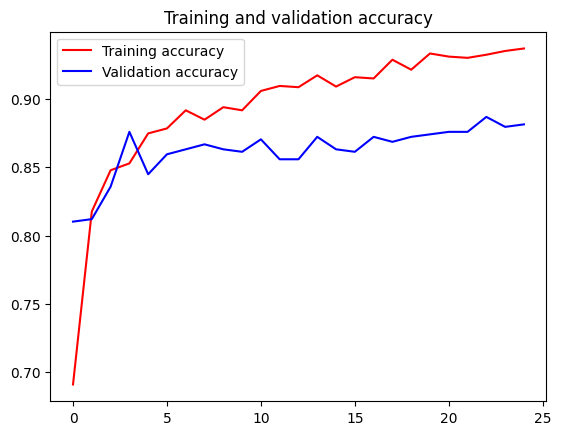

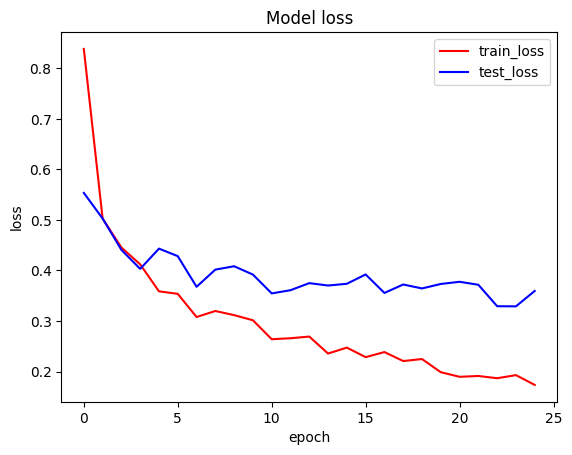

In [ ]:
def plot_train_history(history):
    # Summarize history for accuracy
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend(loc=0)
    plt.figure()

    plt.plot(epochs,loss, 'r', label='train_loss')
    plt.plot(epochs,val_loss, 'b', label='test_loss')
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(loc=0)
    plt.show()


plot_train_history(history)

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

label_names = {0: 'gudeg', 1: 'nasi goreng', 2: 'pempek', 3: 'rendang', 4: 'sate'}

def run_prediction_and_save_labels():
    predictions = []
    images_path = 'images'  # Definisikan variabel images_path di sini

    for i in range(len(testing_generator)):
        idx = random.randint(0, len(testing_generator) - 1)
        predict = model.predict(testing_generator[idx][0])
        predicted_label = np.argmax(predict)
        predictions.append(predicted_label)

    # Save predictions to label.txt
    label_file_path = 'label.txt'
    with open(label_file_path, 'w') as file:
        for prediction in predictions:
            file.write(str(prediction) + '\n')

    # Download label.txt
    from google.colab import files
    files.download(label_file_path)

# Panggil fungsi untuk menjalankan prediksi dan menyimpan label ke dalam file label.txt
run_prediction_and_save_labels()


1/1 [==============================] - 0s 48ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 22ms/step
Prediction for /content/drive/MyDrive/Gambar test/gudeg 2.jpeg: gudeg
Confidence: 0.78837657



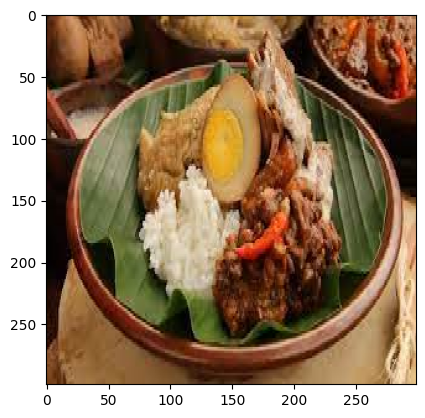

1/1 [==============================] - 0s 21ms/step
Prediction for /content/drive/MyDrive/Gambar test/gudeg 3.jpeg: gudeg
Confidence: 0.86225826



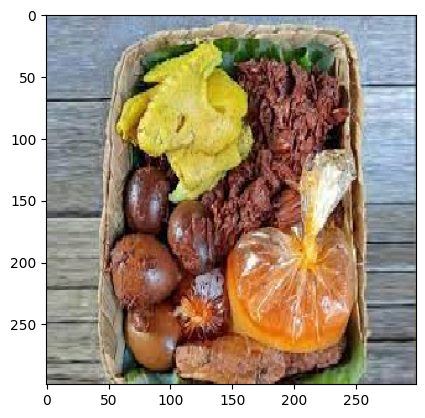

1/1 [==============================] - 0s 21ms/step
Prediction for /content/drive/MyDrive/Gambar test/gudeg-1_43.jpeg: gudeg
Confidence: 0.5434604



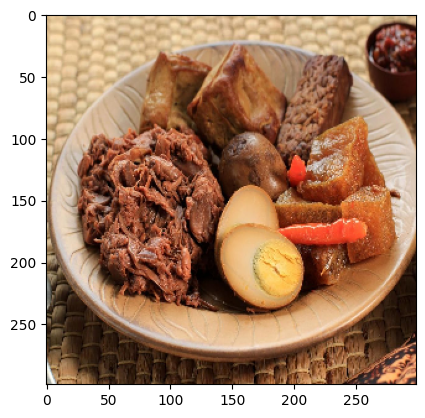

1/1 [==============================] - 0s 25ms/step
Prediction for /content/drive/MyDrive/Gambar test/gudeg.jpeg: gudeg
Confidence: 0.7679124



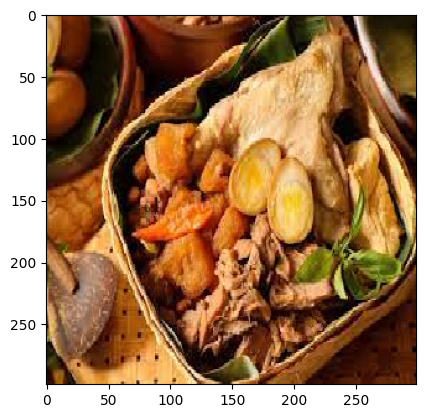

1/1 [==============================] - 0s 21ms/step
Prediction for /content/drive/MyDrive/Gambar test/nasgor 3.jpeg: nasi goreng
Confidence: 0.9997874



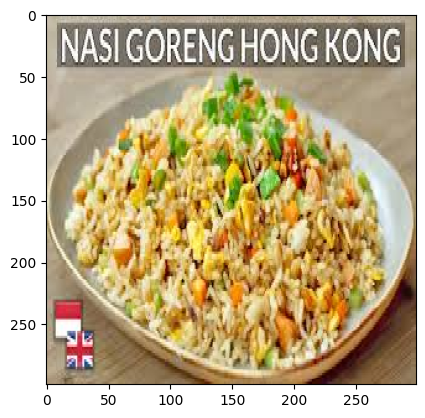

1/1 [==============================] - 0s 23ms/step
Prediction for /content/drive/MyDrive/Gambar test/nasgor.jpeg: nasi goreng
Confidence: 0.9984493



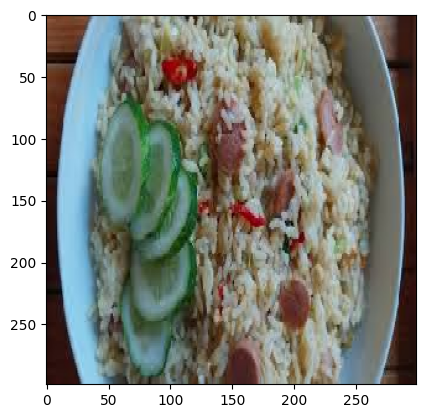

1/1 [==============================] - 0s 32ms/step
Prediction for /content/drive/MyDrive/Gambar test/nasgor 4.jpeg: nasi goreng
Confidence: 0.99502087



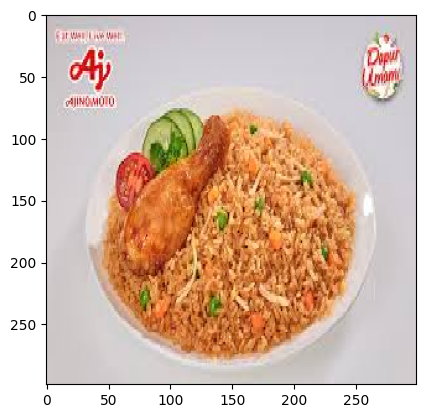

1/1 [==============================] - 0s 21ms/step
Prediction for /content/drive/MyDrive/Gambar test/nasgor 2.jpeg: nasi goreng
Confidence: 0.9990658



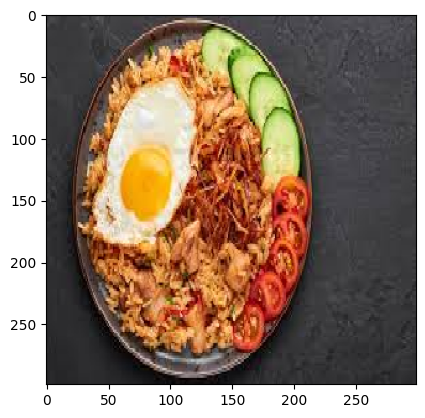

1/1 [==============================] - 0s 31ms/step
Prediction for /content/drive/MyDrive/Gambar test/pempek 2.jpeg: pempek
Confidence: 0.9668983



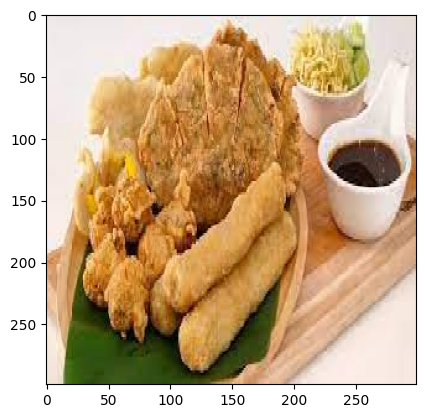

1/1 [==============================] - 0s 25ms/step
Prediction for /content/drive/MyDrive/Gambar test/pempek 3.jpeg: pempek
Confidence: 0.9996935



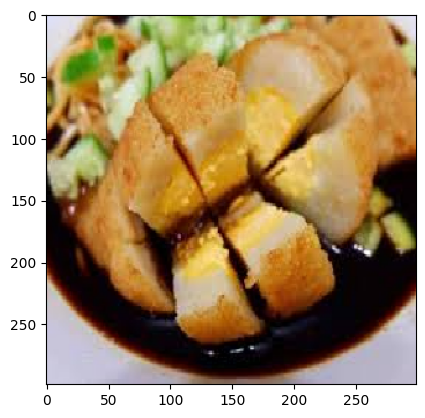

1/1 [==============================] - 0s 23ms/step
Prediction for /content/drive/MyDrive/Gambar test/pempek 1.jpeg: pempek
Confidence: 0.9996456



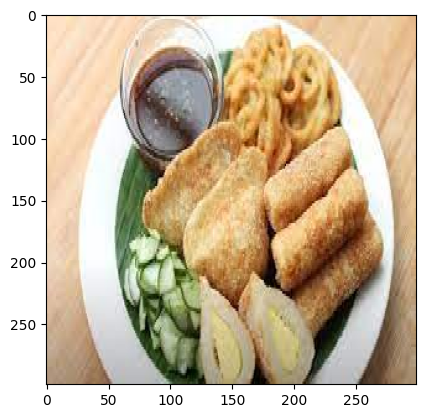

1/1 [==============================] - 0s 22ms/step
Prediction for /content/drive/MyDrive/Gambar test/pempek 4.webp: pempek
Confidence: 0.9987179



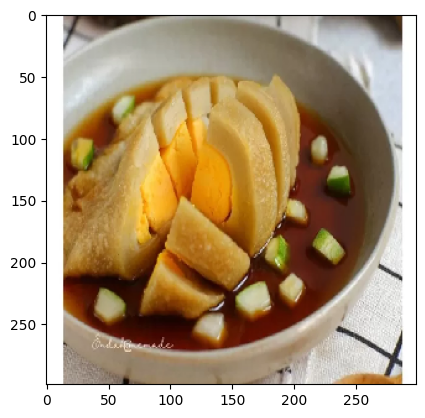

1/1 [==============================] - 0s 21ms/step
Prediction for /content/drive/MyDrive/Gambar test/rendang 3.jpeg: rendang
Confidence: 0.9998857



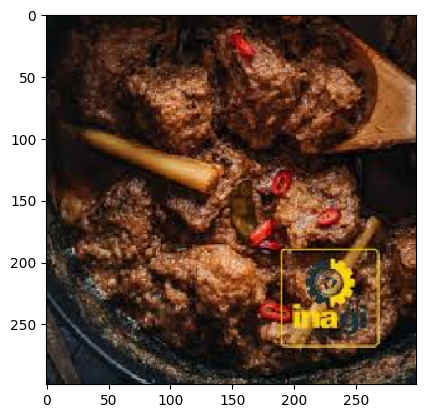

1/1 [==============================] - 0s 22ms/step
Prediction for /content/drive/MyDrive/Gambar test/rendang 4.jpeg: rendang
Confidence: 0.87518346



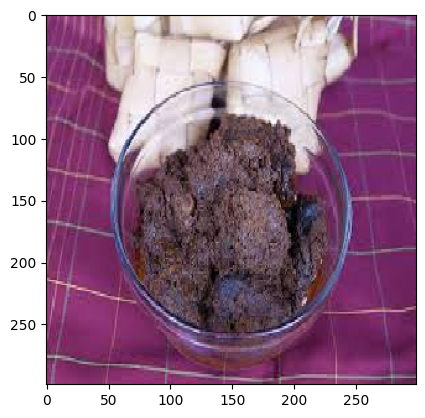

1/1 [==============================] - 0s 30ms/step
Prediction for /content/drive/MyDrive/Gambar test/rendang 2.jpeg: nasi goreng
Confidence: 0.5773804



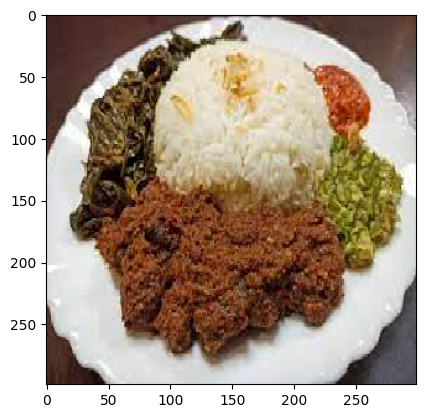

1/1 [==============================] - 0s 31ms/step
Prediction for /content/drive/MyDrive/Gambar test/rendang.jpeg: rendang
Confidence: 0.9996111



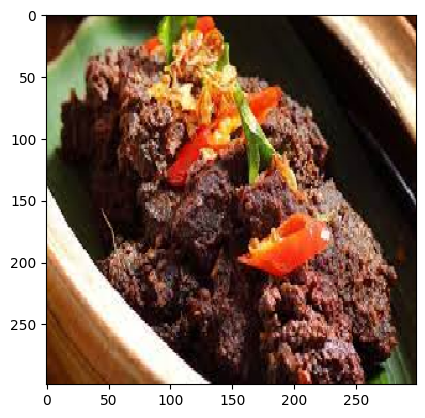

1/1 [==============================] - 0s 32ms/step
Prediction for /content/drive/MyDrive/Gambar test/sate 1.jpeg: sate
Confidence: 0.9997241



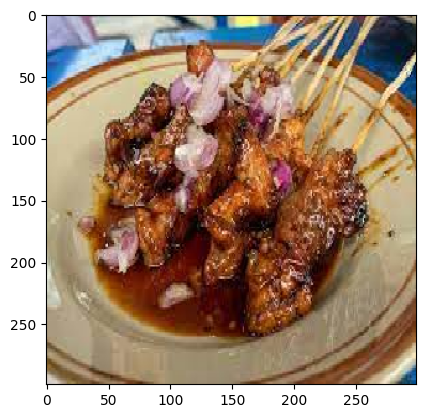

1/1 [==============================] - 0s 37ms/step
Prediction for /content/drive/MyDrive/Gambar test/sate 2.jpeg: sate
Confidence: 0.99690753



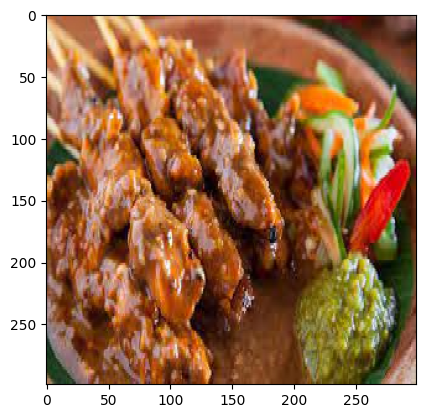

1/1 [==============================] - 0s 30ms/step
Prediction for /content/drive/MyDrive/Gambar test/sate 3.jpeg: sate
Confidence: 0.9716905



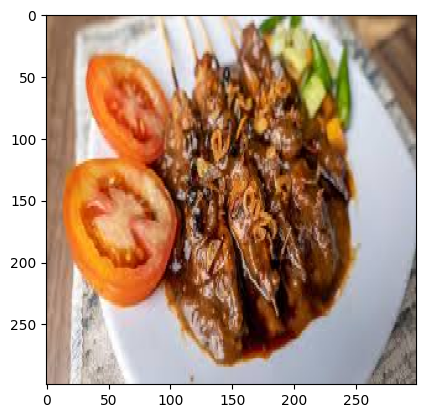

1/1 [==============================] - 0s 21ms/step
Prediction for /content/drive/MyDrive/Gambar test/sate 4.jpeg: sate
Confidence: 0.9999633



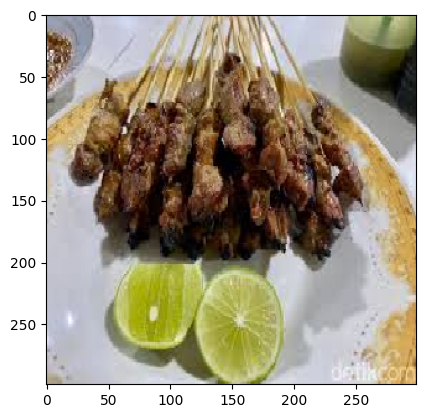

In [ ]:
import numpy as np
from keras.preprocessing import image
import matplotlib.pyplot as plt

file_paths = [
    '/content/drive/MyDrive/Gambar test/gudeg 2.jpeg',
    '/content/drive/MyDrive/Gambar test/gudeg 3.jpeg',
    '/content/drive/MyDrive/Gambar test/gudeg-1_43.jpeg',
    '/content/drive/MyDrive/Gambar test/gudeg.jpeg',
    '/content/drive/MyDrive/Gambar test/nasgor 3.jpeg',
    '/content/drive/MyDrive/Gambar test/nasgor.jpeg',
    '/content/drive/MyDrive/Gambar test/nasgor 4.jpeg',
    '/content/drive/MyDrive/Gambar test/nasgor 2.jpeg',
    '/content/drive/MyDrive/Gambar test/pempek 2.jpeg',
    '/content/drive/MyDrive/Gambar test/pempek 3.jpeg',
    '/content/drive/MyDrive/Gambar test/pempek 1.jpeg',
    '/content/drive/MyDrive/Gambar test/pempek 4.webp',
    '/content/drive/MyDrive/Gambar test/rendang 3.jpeg',
    '/content/drive/MyDrive/Gambar test/rendang 4.jpeg',
    '/content/drive/MyDrive/Gambar test/rendang 2.jpeg',
    '/content/drive/MyDrive/Gambar test/rendang.jpeg',
    '/content/drive/MyDrive/Gambar test/sate 1.jpeg',
    '/content/drive/MyDrive/Gambar test/sate 2.jpeg',
    '/content/drive/MyDrive/Gambar test/sate 3.jpeg',
    '/content/drive/MyDrive/Gambar test/sate 4.jpeg'
    # Add paths for the remaining 18 photos
    # ...
]
for path in file_paths:
    # Load image and resize
    img = image.load_img(path, target_size=(299, 299))
    # Convert image to array and rescale
    x = image.img_to_array(img) / 255
    # Change shape of the image
    x = np.expand_dims(x, axis=0)

    # Make predictions
    classes = model.predict(x, batch_size=10)

    # Get the predicted class name
    label_names = ["gudeg", "nasi goreng", "pempek", "rendang", "sate"]
    prediction_name = label_names[np.argmax(classes[0])]

    # Get the confidence percentage
    confidence_percentage = str(np.max(classes))

    # Print the results for each image
    print(f"Prediction for {path}: {prediction_name}")
    print(f"Confidence: {confidence_percentage}\n")

    # Optionally, display the image
    plt.imshow(img)
    plt.show()

In [ ]:
model.save('modelindonesiafood.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from keras.models import load_model

# load model
model = load_model('modelindonesiafood.h5')

In [ ]:
# new_model= tf.keras.models.load_model(model)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TF Lite model.
with open("model_tflite.tflite", 'wb') as f:
  f.write(tflite_model)
  print("Saved model to disk")

Saved model to disk


In [ ]:
model_json = model.to_json()
with open("model_tf_learning_fix.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("weight_tf_learning_fix.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
!zip -r IndonesiaFood.zip IndonesiaFood

  adding: IndonesiaFood/ (stored 0%)
  adding: IndonesiaFood/validation/ (stored 0%)
  adding: IndonesiaFood/validation/sate/ (stored 0%)
  adding: IndonesiaFood/validation/sate/pic_052.jpeg (deflated 2%)
  adding: IndonesiaFood/validation/sate/pic_263.jpeg (deflated 2%)
  adding: IndonesiaFood/validation/sate/pic_103.jpeg (deflated 1%)
  adding: IndonesiaFood/validation/sate/pic_001.jpeg (deflated 2%)
  adding: IndonesiaFood/validation/sate/pic_492.jpeg (deflated 2%)
  adding: IndonesiaFood/validation/sate/pic_579.jpeg (deflated 2%)
  adding: IndonesiaFood/validation/sate/pic_552.jpeg (deflated 1%)
  adding: IndonesiaFood/validation/sate/pic_141.jpeg (deflated 2%)
  adding: IndonesiaFood/validation/sate/pic_109.jpeg (deflated 2%)
  adding: IndonesiaFood/validation/sate/pic_437.jpeg (deflated 2%)
  adding: IndonesiaFood/validation/sate/pic_561.jpeg (deflated 2%)
  adding: IndonesiaFood/validation/sate/pic_011.jpeg (deflated 2%)
  adding: IndonesiaFood/validation/sate/pic_234.jpeg (defl

In [ ]:
from google.colab import files

files.download('IndonesiaFood.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>